In [1]:
import torch
from torch import nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import mat73
import scipy.io as sio
import sys
from timeit import default_timer as timer
import plotly
import plotly.graph_objs as go
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import open3d as o3d
from torch import nn
np.set_printoptions(threshold=sys.maxsize)

# from utilsReal.optim import Model, training_loop, bruteForce
from utilsReal.generateBasis import generateBasisFunction
from utilsReal.helper import computeVisibility3D, pulse, lowPassFilter
from utilsReal.shape import carving

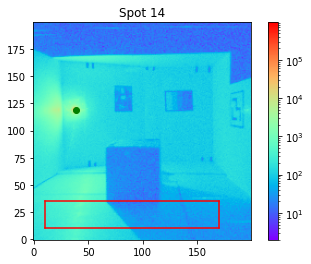

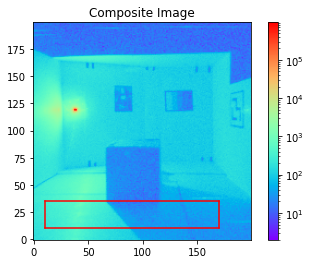

In [334]:
#####################################################################
####################### IMPORT TIME PROFILES ########################
#####################################################################

# data parameters
bin_width = 8E-12
t0 = 14.2428e-9; bin0 = round(t0 / bin_width)
numBins = 8192 - bin0
t = np.linspace(0, bin_width * (numBins-1), numBins)

# plot parameters
plotImgs = True

# detector parameters
num_u = 200; num_v = 200 # dimension of video
y_min = 10; y_max = 35; x_min = 10; x_max = 170 
nc = np.array([0, 0, 1])

numPixels_x = x_max - x_min + 1; numPixels_y = y_max - y_min + 1
x_line = np.linspace(x_min, x_max, numPixels_x); y_line = np.linspace(y_min, y_max, numPixels_y)
x_locs, y_locs = np.meshgrid(x_line, y_line)
det_locs = np.stack((x_locs, y_locs), axis=2).astype(int)

# laser parameters
# spots = [1, 2, 3, 4, 6, 7, 9, 11, 14, 16];
# spots = [4, 6, 7, 9, 11, 14, 16];
# spots = [4, 6, 7, 9, 16];
spots = np.array([i for i in range(1, 17)])
# removeSpots = np.array([6, 7, 9, 10, 11, 15]) - 1
# removeSpots = np.array([1, 5, 6, 7, 9, 10, 11, 15]) - 1
removeSpots = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16]) - 1
las_locs = sio.loadmat('../../data/IBO_Collection/spotLocs.mat')['spot_locs'].astype(int)

if 'removeSpots' in locals():
    spots = np.delete(spots, removeSpots)
    las_locs = np.delete(las_locs, removeSpots, axis=0)
las_locs[:, 1] = num_v - 1 - las_locs[:, 1]
numSpots = len(spots);

# Import pulse
filename = '../../data/Bounce Flash/replica.mat'
pulseShape = np.squeeze(sio.loadmat(filename)['replica'])[bin0:]
pulseShape = np.roll(pulseShape, 50-np.argmax(pulseShape))
# pulseShape = pulseShape / np.max(pulseShape)

# import histograms for relevant pixels
indiv_hists = np.zeros((numPixels_y, numPixels_x, numBins)) # pixels 99-154
observation = np.zeros((num_v, num_u, numBins))
for i in range(numSpots):
    num = str(spots[i])
    filename = '../../data/IBO_Collection/spot_' + num + '.mat'
    dataCube = mat73.loadmat(filename)['dataCube']
    dataCube_r = np.reshape(dataCube[:, bin0:], (num_v, num_u, numBins))
    
    indiv_hists = np.squeeze(dataCube_r[det_locs[:, :, 1], det_locs[:, :, 0], :])
    observation += dataCube_r 
    las_hist = dataCube_r[las_locs[i, 1], las_locs[i, 0], :]
    
    # plot time-integrated images
    if plotImgs:
        plt.figure(); plt.title('Spot ' + str(spots[i]))
        t_int = np.sum(dataCube_r, 2)
        im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
        plt.colorbar(im)
        # plot detector locations
        plt.plot(np.ones(100) * x_min, np.linspace(y_min, y_max, 100), 'r')
        plt.plot(np.ones(100) * x_max, np.linspace(y_min, y_max, 100), 'r')
        plt.plot(np.linspace(x_min, x_max, 100), np.ones(100) * y_min, 'r')
        plt.plot(np.linspace(x_min, x_max, 100), np.ones(100) * y_max, 'r')
        
        # plot laser locations
        plt.plot(las_locs[i, 0], las_locs[i, 1], 'og')
        plt.show()

# indiv_hists2 = lowPassFilter(t, indiv_hists, bin_width, 0.7E10, False)
observations = np.sum(indiv_hists, axis=1)

# plot superimposed image
plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(observation, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)
plt.plot(np.ones(100) * x_min, np.linspace(y_min, y_max, 100), 'r')
plt.plot(np.ones(100) * x_max, np.linspace(y_min, y_max, 100), 'r')
plt.plot(np.linspace(x_min, x_max, 100), np.ones(100) * y_min, 'r')
plt.plot(np.linspace(x_min, x_max, 100), np.ones(100) * y_max, 'r')
plt.show()

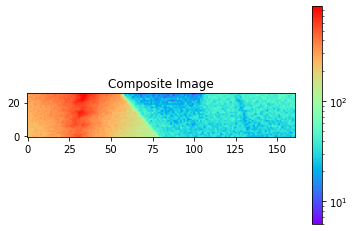

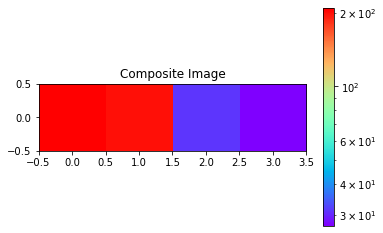

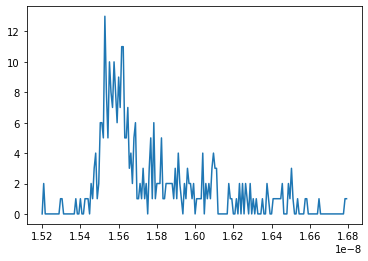

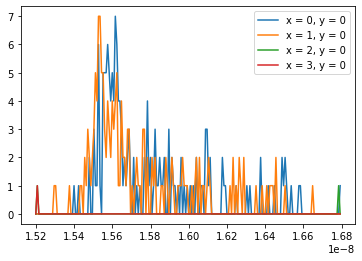

In [339]:
# downsample grid to 50 points
numYsamps = 1
numXsamps = 4
y_locs = np.linspace(0, numPixels_y-1, numYsamps).astype(int) 
x_locs = np.linspace(0, numPixels_x-1, numXsamps).astype(int) 
x_locs, y_locs = np.meshgrid(x_locs, y_locs); xlocs = x_locs.astype(int); y_locs = y_locs.astype(int)
dn_samp_hists = indiv_hists[y_locs, x_locs, :]
# observation = lowPassFilter(t, np.sum(dn_samp_hists, axis=(0, 1)), bin_width, 1E10, False)
observation = np.sum(dn_samp_hists, axis=(0, 1))

# plot ROI and downsampled ROI
plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(indiv_hists, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)

plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(dn_samp_hists, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)

# plot superimposed histogram
plt.figure()
i1 = 1900; i2 = 2100 
plt.plot(t[i1:i2], observation[i1:i2])

# plot superimposed histogram
plt.figure()
leg = []
for x in range(numXsamps):
    for y in range(numYsamps):    
        plt.plot(t[i1:i2], dn_samp_hists[y, x, i1:i2])
        leg.append('x = ' + str(x) + ', y = ' +  str(y))
plt.legend(leg)


In [340]:
dn_samp_hists.shape

(1, 4, 6412)

In [341]:
print(x_locs)
print(y_locs)

[[  0  53 106 160]]
[[0 0 0 0]]


In [318]:
#####################################################################
################### IMPORT GT PHYSICAL PARAMETERS ###################
#####################################################################

# import gt tofs
gt_2b = sio.loadmat('../../data/IBO_Collection/2b_travel_time.mat')['t2']
if 'removeSpots' in locals():
    gt_2b = np.delete(gt_2b, removeSpots, axis=0)
# gt_2b = np.reshape(gt_2b, (numSpots, num_v, num_u))
gt_2b = np.reshape(gt_2b, (1, num_v, num_u))
tofs = gt_2b[0, y_locs, x_locs]

# Import depth, surface normal, and albedo data
filename = '../../data/Bounce Flash/scene.mat'

n_vector = sio.loadmat(filename)['n_p']
n_vector = np.reshape(n_vector, (num_v, num_u, 3))

albedo = np.squeeze(sio.loadmat(filename)['rho2_est'])
albedo = np.reshape(albedo, (num_v, num_u))

pt_loc_v = sio.loadmat(filename)['x_p']
pt_loc = np.reshape(pt_loc_v, (num_v, num_u, 3))

# Save x, y, z data to .ply file if needed
if False:
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pt_loc_v)
    o3d.io.write_point_cloud("../../data/Bounce Flash/sync.ply", pcd)

# Visualize point cloud (WARNING: This will open another window and you will be forced to kill kernal)
if False:
    cloud = o3d.io.read_point_cloud("../../data/Bounce Flash/sync.ply") # Read the point cloud
    o3d.visualization.draw_geometries([cloud])

# specify GT visibility matrix
# vis_gt = np.zeros((numPixels, numSpots))
# vis_gt[41:, 0] = 1 # spot 2
# vis_gt[51:, 1] = 1 # spot 3
# vis_gt[49:, 2] = 1 # spot 4
# vis_gt[58:, 3] = 1 # spot 8
# vis_gt[0:16, 4] = 1 # spot 12
# vis_gt[0:27, 5] = 1 # spot 13
# vis_gt[0:31, 6] = 1 # spot 14
# vis_gt[0:42, 7] = 1 # spot 16

In [342]:
import math
def fourierSeries(t, a, M, numBins, f0, w0, f_samples, plotSpectrum):
    # compute FFT of signal
    a_fft = np.fft.fft(a)
    a_fft_shift = np.fft.fftshift(a_fft)
    f = np.fft.fftfreq(numBins, bin_width)
    f_shift = np.fft.fftshift(f)

    # determine which fourier coefficients to use
    diff = np.abs(np.reshape(f_samples, (2*M+1, 1)) - np.reshape(f_shift, (1, numBins)))
    idx = np.argmin(diff, axis=1)
    # p_hat = a_fft_shift[idx] * 0.45E-2

    # plot FFT of signal and fourier coefficients used
    if plotSpectrum:
        plt.figure()
        plt.title('FFT Magnitude')
        t0 = 0; t1 = numBins
        y = np.abs(a_fft_shift[t0:t1])
        plt.plot(f_shift[t0:t1], y)
        plt.plot(f_shift[idx], y[idx], 'ro')

    # compute fourier series approximation
    m = np.tile(np.reshape(np.linspace(-M, M, 2*M+1), (1, 2*M+1)), (numBins, 1))
    mw_0t = m * np.reshape(w0*t, (numBins, 1))
    comp_exps = np.exp(1j*mw_0t)
    p_hat = f0 * np.sum(np.reshape(a, (numBins, 1))*np.exp(-1j*mw_0t), axis=0) * bin_width
     
    return comp_exps, p_hat

In [405]:
from numpy.linalg import svd
def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

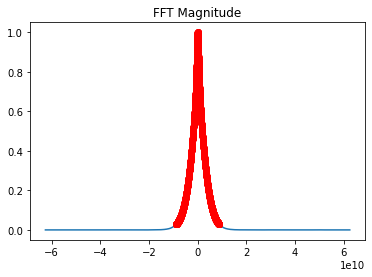

In [495]:
#####################################################################
########################## DETERMINE Y_HAT ##########################
#####################################################################
# observation = np.reshape(observation, (numBins, 1)) # low pass filtered measurements (numBins x 1)
observation = dn_samp_hists[0, 0, :]
observation = np.roll(pulseShape, 100) + 100*np.roll(pulseShape, 250)

M = 450
plotSpectrum = True
T = (numBins-1)*bin_width
f0 = 1/T; w0 = 2*math.pi*f0
f_samples = f0 * np.reshape(np.linspace(-M, M, 2*M+1), (2*M+1, 1))
exps_p, p_hat = fourierSeries(t, pulseShape, M, numBins, f0, w0, f_samples, True)

m_t = observation # low-pass filtered measurements (N x 1)
V = exps_p # Vandermonde matrix (N x (2M + 1))
D = np.diag(p_hat) # diagonal matrix containing pulse Fourier coefficients (2M+1) x (2M+1)
D_inv = np.diag(1 / p_hat)

y_hat = np.matmul(np.matmul(D_inv, np.linalg.pinv(V)), m_t)

Prediction 1:
[0.79980766 2.00000144]
[ 99.97595708 250.00017958]


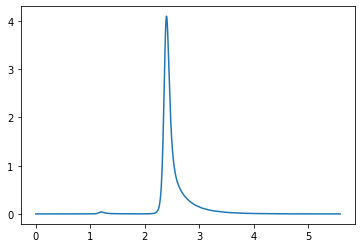

In [496]:
#####################################################################
########################## PRONY'S METHOD ###########################
#####################################################################
K = 2
y_hat_cut = np.squeeze(y_hat[M+1:])

# generate Toeplitz matrix to solve for q
T = np.zeros((M-K, K+1)) + 0j
# for i in range(K+1):
#     idx1 = (K+1-i)-1; idx2 = 2*K-i
#     T[:, i] = y_hat_cut[idx1:idx2]
for i in range(M-K):
    idx1 = i; idx2 = K+1+i
    T[i, :] = np.flipud(y_hat_cut[idx1:idx2])

# solve polynomial to obtain q
q = nullspace(T, 1E-12, 5E-4)
# print(q.shape)

# 
for i in range(q.shape[1]):
    print('Prediction ' + str(i+1) +':')
    e_t_k = np.roots(np.squeeze(q[:, i]))
    t_k = -1E9*np.angle(e_t_k) / w0
    print(t_k)
    print(t_k / (1E9*bin_width))

i1 = 0; i2 = 700
plt.plot(t[i1:i2]*1E9, observation[i1:i2])

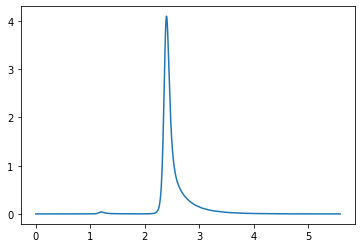

In [490]:
i1 = 0; i2 = 700
plt.plot(t[i1:i2]*1E9, observation[i1:i2])

In [285]:
y_hat_cut = np.squeeze(y_hat[M+1:])
print(y_hat_cut.shape)

(400,)


In [275]:
def dot(vec1, vec2):
    # input: m x n x 3 matrices
    return np.sum(vec1 * vec2, axis=-1)

In [276]:
#####################################################################
####################### COMPUTE GAMMA AND PHI #######################
#####################################################################
c = 299792458

# compute pixel-wise positions in real-world coordinates
det_x = pt_loc[y_locs, x_locs, 0]
det_y = pt_loc[y_locs, x_locs, 1]
det_z = pt_loc[y_locs, x_locs, 2]

las_x = pt_loc[las_locs[0, 1], las_locs[0, 0], 0]
las_y = pt_loc[las_locs[0, 1], las_locs[0, 0], 1]
las_z = pt_loc[las_locs[0, 1], las_locs[0, 0], 2]

# compute pixel-wise tof
r1 = (las_x**2 + las_y**2 + las_z**2)**0.5 
r2 = ((det_x-las_x)**2 + (det_y-las_y)**2 + (det_z-las_z)**2)**0.5
r3 = (det_x**2 + det_y**2 + det_z**2)**0.5
pathLen = r1 + r2 + r3
tof = (pathLen / c) - 6.4E-10
phi = w0 * tof
# tof += t0
r2_squared = r2**2

# compute pixel-wise albedos
rho1 = albedo[las_locs[0, 1], las_locs[0, 0]]
rho2 = albedo[y_locs, x_locs]

# compute pixel-wise surface normals
n1 = np.reshape(n_vector[las_locs[0, 1], las_locs[0, 0], :], (1, 1, 3))
n2 = n_vector[y_locs, x_locs, :]

# compute propogation vectors
wc1_unnorm = np.reshape(pt_loc[las_locs[0, 1], las_locs[0, 0], :], (1, 1, 3))
wc1 = wc1_unnorm / (np.sum(wc1_unnorm**2)**0.5)
w1c = -wc1
wc2_unnorm = pt_loc[y_locs, x_locs, :]
wc2 = wc2_unnorm / np.reshape(np.sum(wc2_unnorm**2, 2)**0.5, (numYsamps, numXsamps, 1))
w12_unnorm = wc2_unnorm - wc1_unnorm
w12 = w12_unnorm / np.reshape(np.sum(w12_unnorm**2, 2)**0.5, (numYsamps, numXsamps, 1))
w21 = -w12
    
Gamma = 3000 * rho1 * rho2 * (dot(w12, n1) * dot(w21, n2) * dot(wc2, nc) / r2_squared)

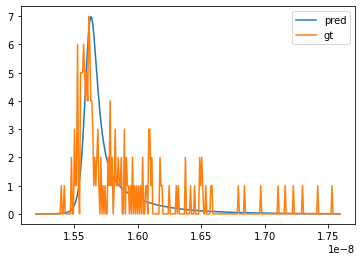

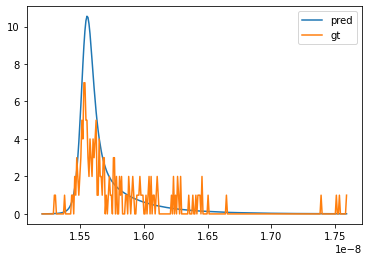

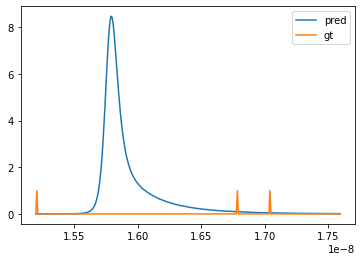

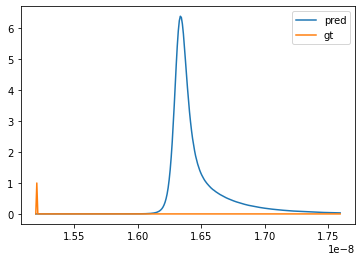

In [277]:
row = 0
i1 = 1900; i2 = 2200
for i in range(numXsamps):
    pred_hists = Gamma[row, i] * np.roll(pulseShape, int(np.round(tof[row, i] / bin_width)))
    gt_hist = dn_samp_hists[row, i, :]
    plt.figure()
    plt.plot(t[i1:i2], pred_hists[i1:i2])
    plt.plot(t[i1:i2], gt_hist[i1:i2])
    plt.legend(['pred', 'gt'])

In [278]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, numPixels):
        super().__init__()
        # initialize weights with random numbers
        vis = torch.rand(numPixels)
        vis = torch.where(vis > 0.5, 1, -1) + torch.tensor(0j, dtype=torch.cdouble)
        
        # make weights torch parameters
        self.vis = nn.Parameter(vis, requires_grad = True)      
        
    def forward(self, A):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        vis = torch.sigmoid(torch.abs(self.vis)) + 0j
        obs = torch.matmul(A, vis)
        return obs
    
def complexLoss(target, output):
    loss = torch.sum(torch.abs(output - target)) / target.shape[0]
    return loss

def training_loop(model, A, y_hat, optimizer, thresh, lam, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        preds = model(A)
        loss1 = complexLoss(preds, y_hat) 
        vis_resh = torch.reshape(torch.sigmoid(torch.abs(model.vis)), (numYsamps, numXsamps))
#         vis_resh = torch.sigmoid(torch.abs(torch.tensor(np.reshape(model.vis.detach().numpy(), (5, 10), order = 'C'))))
        loss2 = torch.sum(torch.square(torch.diff(vis_resh, n=1, axis=0))) + torch.sum(torch.square(torch.diff(vis_resh, n=1, axis=1)))
        loss = loss1 + lam * loss2
#         print(loss1)
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

[0.57132283 0.36678942 0.49977016 0.50015586]


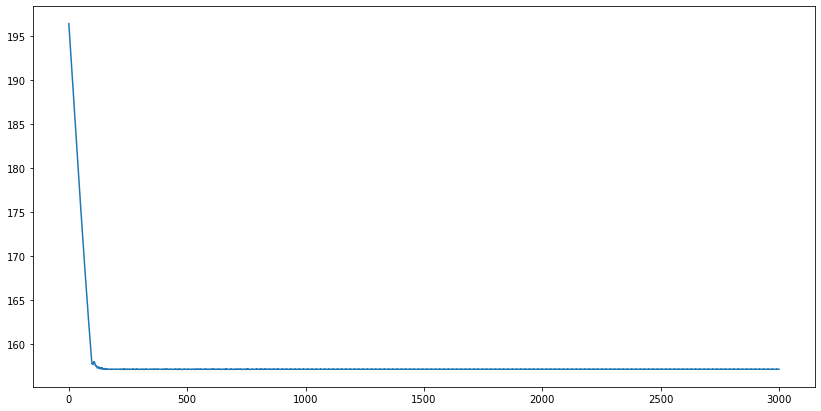

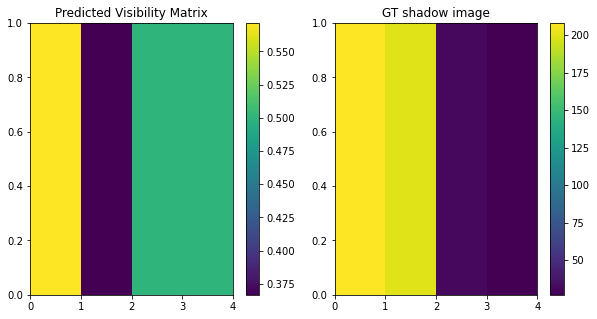

In [279]:
#####################################################################
####################### SOLVE FOR VISIBILITY ########################
#####################################################################
# construct A matrix 
phi_flat = np.reshape(np.ndarray.flatten(phi, order='C'), (1, numXsamps*numYsamps))
comp_exps = np.exp(-1j * phi_flat * np.tile(np.reshape(np.linspace(-M, M, 2*M+1), (2*M+1, 1)), (1, numXsamps*numYsamps)))
Gamma_flat = np.reshape(np.ndarray.flatten(Gamma, order='C'), (1, numXsamps*numYsamps))
A = Gamma_flat * comp_exps
y_hat = np.squeeze(y_hat)

# optimization
thresh = 1E-100
numIters = 3000
lr_rate = 1E-2
lam = 0.5E2
plotError = True
m = Model(numXsamps*numYsamps)
opt = torch.optim.Adam(m.parameters(), lr=lr_rate)
losses = training_loop(m, torch.tensor(A), torch.tensor(y_hat), opt, thresh, lam, numIters)
vis = torch.real(m.vis.detach())
vis = torch.sigmoid(vis)
v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
v_reconst = vis.numpy()
print(v_reconst)

# plot optimization loss
if plotError:
    plt.figure(figsize=(14, 7))
    plt.plot(losses)

plt.figure(figsize=(10, 5)); 
plt.subplot(1, 2, 1)
plt.title('Predicted Visibility Matrix')
plt.pcolormesh(np.reshape(v_reconst, (numYsamps, numXsamps), order='C')); plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('GT shadow image')
plt.pcolormesh(np.sum(dn_samp_hists, 2)); plt.colorbar()


# im = plt.imshow(np.sum(dn_samp_hists, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
# plt.colorbar(im)

# im = plt.imshow(np.sum(dn_samp_hists, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
# plt.colorbar(im)
# compare ground truth visibility matrix
# error = np.sum(np.abs(v_reconst-vis_gt))
# pct_error = 100 * error / (numSpots * numPixels)
# print(str(error) + ' / ' + str(numPixels*numSpots) + ' entries in visibility matrix misclassified')
# print(str(pct_error) + '% of entries in visibility matrix misclassified')

# onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
# print(str(onesToZero) + ' ones flipped to zeros')
# print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
# end = timer()
# print(end - start)

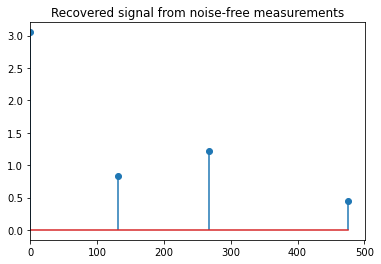

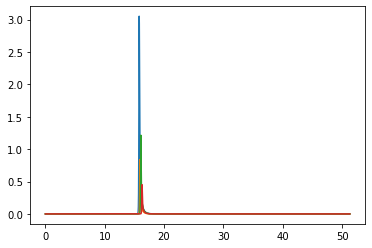

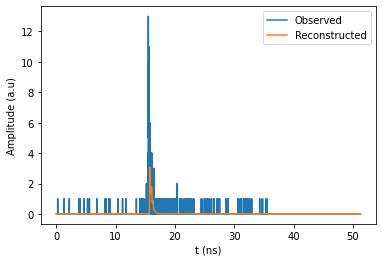

In [280]:
#####################################################################
###################### DETERMINE 2-BOUNCE TOFs ######################
#####################################################################
from sklearn.linear_model import OrthogonalMatchingPursuit

# construct dictionary matrix P
t_min = 15.4; t_max = 15.9 # in nanoseconds
inc_size = 1E-12
L = 1 + int((t_max - t_min) / (inc_size * 1E9))
shifts = 1E-9 * np.linspace(t_min, t_max, L)
P = np.zeros((numBins, L))
for i in range(L):
    a = np.roll(pulseShape, round(shifts[i] / bin_width))
    P[:, i] = np.array(a) / np.max(a)
    
# compute K-sparse representation
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=4, normalize=False)
# observation = observations[-1, :]
# observation = reconst_filt
omp.fit(P, observation)

# plot sparse recovery
coef = omp.coef_
(idx_r,) = coef.nonzero()
tof_preds = shifts[idx_r]
plt.figure()
plt.xlim(0, L)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot reconstructed sparse signal
plt.figure()
reconst = np.zeros(numBins)
t0 = 0; t1 = -1; t_val = t[t0:t1]; 
for i in idx_r:
    if coef[i] > -60000:
        reconst += coef[i] * P[:, i]
        plt.plot(1E9*t_val, coef[i] * P[t0:t1, i])
plt.figure()
plt.plot(1E9*t_val, observation[t0:t1])
plt.plot(1E9*t_val, reconst[t0:t1])
plt.xlabel('t (ns)')
plt.ylabel('Amplitude (a.u)')
plt.legend(['Observed', 'Reconstructed'])

--------------------------------------------------
GT tof
[1.56571924e-08 1.55504518e-08]
--------------------------------------------------
Estimated tof
[1.5400e-08 1.5668e-08 1.5532e-08 1.5876e-08 1.5559e-08 1.5560e-08
 1.5561e-08 1.5562e-08]
--------------------------------------------------
GT Weights
[7. 7.]
--------------------------------------------------
Estimated Weights
[3.05197975 1.21500697 0.83983074 0.45089398 0.         0.
 0.         0.        ]


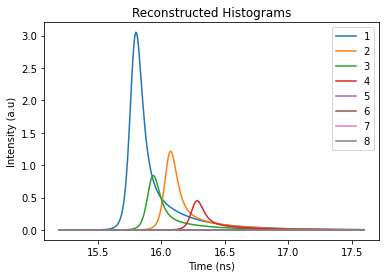

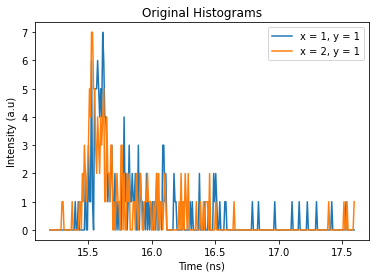

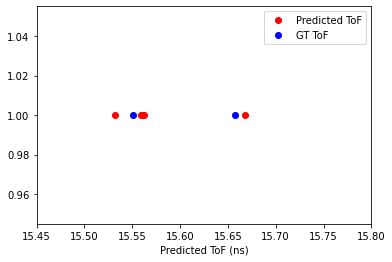

In [282]:
numSpots = 8; pixNumb = 0; 
gt_weight = np.max(dn_samp_hists, axis=2)
idx_r_sort = np.flip(np.argsort(coef))[0:numSpots]
plt.figure()
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u)')
plt.title('Reconstructed Histograms')
leg = []
for i in range(numSpots):
    plt.plot(1E9*t[i1:i2], coef[idx_r_sort[i]]*P[i1:i2, idx_r_sort[i]])
    leg.append(str(i+1))
plt.legend(leg)
plt.figure()
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u)')
plt.title('Original Histograms')
leg = []; 
for x in range(2):
    for y in range(numYsamps):
        a = dn_samp_hists[y, x, :]
#         filt = lowPassFilter(t, a, bin_width, 0.5E10, False)
        plt.plot(t[i1:i2]*1E9, a[i1:i2])
        leg.append('x = ' + str(x+1) + ', y = ' + str(y+1))
plt.legend(leg)
print('-'*50)
print('GT tof')
print(np.ndarray.flatten(tofs[:, 0:2]))
print('-'*50)
print('Estimated tof')
print(shifts[idx_r_sort])
print('-'*50)
print('GT Weights')
print(np.ndarray.flatten(gt_weight[:, 0:2]))
print('-'*50)
print('Estimated Weights')
print(coef[idx_r_sort])
plt.figure()
plt.xlabel('Predicted ToF (ns)')
plt.plot(1E9*shifts[idx_r_sort], np.ones(len(idx_r_sort)), 'ro')
plt.plot(1E9*np.ndarray.flatten(tofs[:, 0:2]), np.ones(2), 'bo')
plt.xlim([15.45, 15.8])
plt.legend(['Predicted ToF', 'GT ToF'])

In [ ]:
#####################################################################
##################### GENERATE BASIS FUNCTIONS ######################
#####################################################################
    
# generate histogram profiles for each source-detector pair
t0 = 9.838954918822267e-09
scale = 3000
# t0 = -3.3E-7

c = 299792458
t0 = 0

# tofs -= t0 #+ 10e-9
# tof, hists = generateBasisFunction(albedo, n_vector, pt_loc, las_locs, det_locs, nc, t, t0, pulseShape, bin_width, scale, c, tofs)

# plot basis functions for each spot
# t1 = 0; t2 = 8192
# # t1 = 3500; t2 = 3600
# t1 = 3000; t2 = 4300
# for j in range(numSpots):
#     plt.figure()
#     for i in range(0, numPixels):
#         plt.plot(t[t1:t2], hists[i, j, t1:t2], 'b')
#         plt.plot(t[t1:t2], indiv_hists[i, j, t1:t2], 'r')

In [ ]:
#####################################################################
####### SOLVE INVERSE PROBLEM (RECONSTRUCT VISIBILITY MATRIX) #######
#####################################################################

c = 299792458# 3E8 / 1.0003
# optimization parameters
numIters = 3000
thresh = 1E-100
lr_rate = 0.1
lam = 0 # 5E2 for noiseless case

# object parameters
pixelSize = 0.01 # meters

# plotting parameters
plotData = False
plotError = False
plotSetup = True  
    
# t0s = np.array([6E-9, 7E-9, 8E-9, 9E-9, 1E-8, 1.1E-8, 1.2E-8]) + 14.26E-9 
t0s = np.array([0E-9, 0.5E-9, 1E-9, 1.5E-9, 2E-8, 2.5E-8, 3E-8]) #- 10E-9
# t0s = [0]
i = 0
plt.figure(figsize=(18,3))
plt.xlabel('Spot Number')
plt.ylabel('Pixel Number')
plt.subplot(1, len(t0s)+1, 1)
plt.pcolormesh(vis_gt)
plt.title('Ground Truth')
for t0 in t0s:
    i += 1
    # generate basis functions
    scale = 2965
    tof, hists = generateBasisFunction(albedo, n_vector, pt_loc, las_locs, det_locs, nc, t, t0, pulseShape, bin_width, scale, c, tofs)

    # gradient descent
    m = Model(numPixels, numSpots)
    opt = torch.optim.Adam(m.parameters(), lr=lr_rate)
    # obs_filt = torch.tensor(observations * (observations != 0) / np.max(observations, axis=1))
    # hists_norm = torch.tensor(hists / np.max(hists, axis=2))
    obs_filt = torch.tensor(observations)
    hists_norm = torch.tensor(hists)
    losses = training_loop(m, hists_norm, obs_filt, opt, thresh, lam, n=500)
    vis = m.vis.detach()
    vis = torch.sigmoid(vis)
    v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
    # v_reconst = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

    # plot optimization loss
    if plotError:
        plt.figure(figsize=(14, 7))
        plt.plot(losses)

    # plot visibility matrix
    plt.subplot(1, len(t0s)+1, i+1)
    plt.pcolormesh(v_reconst)
    plt.title('t0 = ' + str(t0))

    # compare ground truth visibility matrix
    # error = np.sum(np.abs(v_reconst-vis_gt))
    # pct_error = 100 * error / (numSpots_y * numPixels_z * numPixels_y)
    # print(str(error) + ' / ' + str(numPixels_z * numPixels_y * numSpots_y) + ' entries in visibility matrix misclassified')
    # print(str(pct_error) + '% of entries in visibility matrix misclassified')

    # onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
    # print(str(onesToZero) + ' ones flipped to zeros')
    # print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
    # end = timer()
    # print(end - start)

In [ ]:
class t0Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        super().__init__()
        # initialize weights with random numbers
        t0 = torch.tensor(1E-8)
        
        # make weights torch parameters
        self.t0 = nn.Parameter(t0, requires_grad=True)      
        
    def forward(self, indiv_hists, pulses_fft, f_tiled):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        numPixels, numSpots, numBins = indiv_hists.shape
        tof = torch.tile(torch.reshape(self.t0, (1, 1, 1)), (numPixels, numSpots, numBins))
        freq_shift = pulses_fft * torch.exp(-1j * 2*math.pi*f_tiled*tof) 
                         
        new_hists = torch.abs(torch.fft.ifft(freq_shift))
        corr = torch.sum(new_hists * indiv_hists)
        return corr

def t0_training_loop(model, indiv_hists, pulses_fft, f_tiled, optimizer, thresh, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        corr = model(indiv_hists, pulses_fft, f_tiled)
        loss = -corr
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

pulses_fft = np.fft.fft(hists)
f = np.reshape(np.fft.fftfreq(numBins, bin_width), (1, 1, numBins))
f_tiled = np.tile(f, (numPixels, numSpots, 1)) 
                         
mt = t0Model()
opt = torch.optim.Adam(mt.parameters(), lr=lr_rate)
losses = t0_training_loop(mt, torch.tensor(indiv_hists), torch.tensor(pulses_fft), torch.tensor(f_tiled), opt, 1E-100, n=500)
t0_guess = mt.t0.detach()